<!-- Assignment 1 - SS 2023 -->

# Deep Learning with Pytorch (0 points)

This notebook contains one of the assignments for the exercises in Deep Learning and Neural Nets 2.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility functions that should work without (too much) problems.
Please, do not alter this code or add extra import statements in your submission, unless explicitly allowed!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, the main goal is to get familiar with deep learning in pytorch.
At the same time it should help you refresh what you (should have) learned in DL & NN 1.

In [1]:
import inspect
import torch
import torchvision
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

torch.manual_seed(1806);

c:\Users\Q540900\AppData\Local\anaconda3\envs\dlnn2\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Die angegebene Prozedur wurde nicht gefunden'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# google colab data management
import os.path

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    _home = 'gdrive/MyDrive/'
except ImportError:
    _home = '~'
finally:
    data_root = os.path.join(_home, '.pytorch')

print(data_root)

~\.pytorch


## Deep Learning Frameworks

There are plenty of freely available frameworks that can be used for deep learning.
Although most frameworks are written using low-level programming languages for speed,
most of them provide bindings for [python](https://docs.python.org/3).
Therefore, python has become the number one machine/deep learning language.

In DL&NN 1, we already learned how [numpy](https://docs.scipy.org/doc/numpy) can be used to implement a neural network.
Although numpy provides highly optimised code for linear algebra, it does not support any hardware acceleration.
Graphical Processing Units (GPUs) have become one of the main hardware accelerators for deep learning 
(and more generally, for matrix multiplications).
In order to accelerate python and/or numpy code on a GPU, one could use a framework like [numba](http://numba.pydata.org/) or even [pycuda](https://documen.tician.de/pycuda/).
More recently, Tensor Processing Units (TPUs) were developed (by Google) to further accelerate deep learning computations.
Accelerating your python code for TPUs (also works for GPUs) can be achieved by [jax](https://jax.readthedocs.io/en/latest/).

Apart from the TPU/GPU acceleration, jax also provides automatic differentiation for python or numpy code.
This means that once the forward pass of the network has been implemented, 
the framework is able to compute the gradients for the backward pass automatically.
Whereas all of these frameworks enhance numpy to make it a more powerful tool for deep learning,
the "*true*" deep learning frameworks offer hardware acceleration and differentation out of the box.

###### Theano and Tensorflow v1

One of the first frameworks for deep learning, [Theano](http://www.deeplearning.net/software/theano/) was developed by MILA.
The core idea of Theano is to build computational graphs that can then be optimised and are executed in a second phase.
```python
# single layer network in Theano (untested)
import numpy as np
import theano
import theano.tensor as T

class Network:
    """ Represents the computational graph of the network. """

    def __init__(self, x):
        self.x = x   # x would be a graph node representing the input
        self.w = theano.shared(value=np.zeros(x.shape[-1], 1), name='W')
        self.b = theano.shared(value=np.zeros(1, ), name='b')

    @property
    def pre_activation(self):
        """ 
        Construct graph node that computes pre-activations.
        Does NOT compute pre-activations!
        """
        return T.dot(self.x, self.w) + self.b

    @property
    def activation(self):
        """ 
        Construct graph node that computes pre-activations.
        Does NOT compute activations!
        """
        return 1 / (1 + T.exp(-self.pre_activation))
```

Theano by itself has been discontinued, but the ideas in Theano have been adopted by the Google engineers
that created the first version of [Tensorflow](https://www.tensorflow.org/versions#tensorflow_1x).
```python
# single layer network in Tensorflow v1
import numpy as np
import tensorflow as tf

class Network:
    """ Represents the computational graph of the network. """

    def __init__(self, x):
        self.x = x   # x would be a graph node representing the input
        self.w = tf.Variable(tf.zeros((x.shape[-1], 1)))
        self.b = tf.Variable(tf.zeros(1))

    @property
    def pre_activation(self):
        """ 
        Construct graph node that computes pre-activations.
        Does NOT compute pre-activations!
        """
        return tf.matmul(self.x, self.w) + self.b

    @property
    def activation(self):
        """ 
        Construct graph node that computes pre-activations.
        Does NOT compute activations!
        """
        return 1 / (1 + tf.exp(-self.pre_activation))

# construct graph
x = tf.placeholder(dtype=tf.float32, shape=(None, 5))
network = Network(x)
w_grad,  = tf.gradients(network.activation, [network.w])  # automatic differentiation

# run through the network
data = np.random.randn(10, 5)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    a, w_grad = sess.run([network.activation, w_grad], feed_dict={network.x: data})
```

###### Pytorch and Tensorflow v2

The graph building in theano and tensorflow v1 can be used for optimisation,
but its main goal is to allow automatic differentiation through this graph (in reverse mode).
Instead of relying on automatic differentation through a graph, 
it is also possible to just implement the analytical derivatives for every basic function.
This is the approach that the Facebook engineers used in torch and [pytorch](https://pytorch.org/).
By tracking the function calls in the forward pass, 
the backward pass does not need to be implemented separately.
```python
import torch
from torch import nn

class Network(nn.Module):
    
    def __init__(self, num_in: int):
        super().__init__()
        self.w = nn.Parameter(torch.zeros(num_in, 1))
        self.b = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        s = torch.dot(x, self.w) + self.b
        return torch.sigmoid(s)

x = torch.randn(10, 5)
network = Network(x.shape[-1])
network.zero_grad()
a = network(x)
a.backward()
w_grad = network.w.grad
```

A similar approach has been taken for the second version of [Tensorflow](https://www.tensorflow.org/versions#tensorflow_20).
Instead of building graphs, tensorflow v2 operates in the so-called *eager mode* by default
and makes use of a *gradient tape* to keep track of the graph.
```python
# single layer network in Tensorflow v2
import tensorflow as tf

class Network:
    """ Represents the network. """

    def __init__(self, num_in):
        self.w = tf.Variable(tf.zeros((num_in, 1)))
        self.b = tf.Variable(tf.zeros(1))

    def forward(self, x):
        s = tf.matmul(x, self.w) + self.b
        return 1 / (1 + tf.exp(-s))

# run through the network
x = tf.random.normal((10, 5))
network = Network(x.shape[-1])
with tf.GradientTape() as tape:
    tape.watch(network.w)
    a = network.forward(x)
w_grad = tape.gradient(a, network.w)
```

###### Other Libraries

Although Tensorflow and Pytorch are the most commonly used frameworks for deep learning,
there are plenty of alternatives, most of which are open source. Some examples are:
 * [CogNitive ToolKit (CNTK)](https://docs.microsoft.com/en-us/cognitive-toolkit/) (Microsoft)
 * [nnabla](https://nnabla.org/) (Sony)
 * [mxnet](https://mxnet.apache.org/) (Apache)
 * [Chainer](https://chainer.org/) (Preferred Networks)
 * ...

There are also plenty of libraries that build upon these frameworks.
Mostly, these frameworks are easier to use, but therefore harder to customise.
Some noteable examples are:
 * [Lasagne](https://lasagne.readthedocs.io/en/latest/) (unmaintained) 
 was intended to make stacking layers with Theano easier.
 * [Keras](https://keras.io/) (F. Chollet, Google) is to be considered an API. 
 Reference implementations exist for Theano, TF, CNTK and numpy (for inference).
 NOTE: tensorflow completely incorporated the Keras API.
 * [Caffe](https://caffe.berkeleyvision.org/) (BAIR) and [Caffe 2](https://caffe2.ai) (Facebook, discontinued) 
 allow(ed) to define models by means of configuration files. Caffe 2 has been merged into pytorch.
 * [Sonnet](https://github.com/deepmind/sonnet) and [dm-haiku](https://github.com/deepmind/dm-haiku) (Deepmind, experimental)
 are frameworks built on top of tensorflow and jax, respectively, to abstract away some of the pesky details.
 * ...

In this course, we will be using **pytorch** as the main framework,
because it has gained massive popularity over the last few years
and enables to write pythonic code for deep learning.

## Neural Networks

The pytorch code for building neural networks is mainly grouped in the `torch.nn` submodule.
E.g. fully connected layers are implemented in the [`torch.nn.Linear`](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) class, 
convolutional layers (for images) can be used as [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d),
and highly optimised versions of LSTMS are available through [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM).
Also plenty of [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity),
[loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions),
[normalisation methods](https://pytorch.org/docs/stable/nn.html#normalization-layers) 
are readily available in the `torch.nn` submodule. To easily stack all of these layers,
there is also the [`torch.nn.Sequential`](https://pytorch.org/docs/stable/nn.html#sequential) module and much more.
Because this submodule provides so much useful tools,
it is common to import the submodule directly using `from torch import nn`,
as has been done at the start of this notebook.

### Exercise 1: Fully Connected Network (0 points)

Time to get familiar with the DL module in the `nn` submodule.
Let us build a fully connected network to classify the [MNIST](http://yann.lecun.com/exdb/mnist/) images.

 > Construct a new pytorch module, by writing a class that inherits from `nn.Module`.
 > The pytorch module should represent a network with three fully connected layers.
 > The hidden layers should have 500 and 300 units and the output layer returns the logits.
 > For the activation function in the hidden layers, you can use the hyperbolic tangent.

In [3]:
class FCNetwork(nn.Module):
    """ Network with fully-connected layers. """
    
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Number of input dimensions.
        out_features : int
            Number of output dimensions.
        """
        # YOUR CODE HERE
        super(FCNetwork, self).__init__()

        # First fully connected layer
        self.fc1 = nn.Linear(in_features=in_features, out_features=500)
        # Second fully connected layer
        self.fc2 = nn.Linear(in_features=500, out_features=300)
        # Third fully connected layer
        self.fc3 = nn.Linear(in_features=300, out_features=out_features)

        # Hyperbolic tangent activation function
        self.tanh = nn.Tanh()

    def forward(self, x):
        # First layer with activation funcion
        x = self.tanh(self.fc1(x))
        # Apply second layer
        x = self.tanh(self.fc2(x))
        # Third layer
        x = self.fc3(x)

        return x

In [4]:
# sanity check
fc_net = FCNetwork(784, 10)
fc_net(torch.randn(1, 784))
sum([par.numel() for par in fc_net.parameters()])

545810

In [5]:
# Test Cell: do not edit or delete!

In [6]:
# Test Cell: do not edit or delete!

In [7]:
# Test Cell: do not edit or delete!

In [8]:
# Test Cell do not edit or delete!

In [9]:
# Test Cell: do not edit or delete!

In [10]:
# Test Cell: do not edit or delete!

### Exercise 2: Convolutional Network (0 points)

Instead of creating a new class, we can also use the `Sequential` module.
Since convolutional networks are generally better suited to images,
we will build a MNIST classifier with convolutional layers this time.
Any other benefits of convolutional layers you can think of?

 > Use the `Sequential` module to construct a network with two convolutional layers.
 > The inputs for this network are single-channel 28x28 images.
 > The result of the first convolutional layer should have **five 24x24 feature maps**.
 > The second convolutional layer should receive **five 6x6 feature maps** as input
 > and produce **ten 3x3 feature maps**.
 > Use average pooling for the dimensionality reduction between the two convolutional layers.
 > Finally, add a fully-connected layer to map the feature maps to logits for 10 distinct classes.
 > Use the Exponential Linear Unit (ELU) as activation function.

In [11]:
# TODO: create network with `nn.Sequential`
conv_net = nn.Sequential(
    # First convolutional layer
    nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5), # 28-5+1=24
    nn.ELU(),
    # Average pooling layer
    nn.AvgPool2d(kernel_size=2, stride=4), # 24-2/4
    # Second convolutional layer
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=4),
    nn.ELU(),
    # Flatten the output 
    nn.Flatten(),
    # Fully connected layer
    nn.Linear(in_features=10*3*3, out_features=10)  # Mapping to 10 classes
)
# YOUR CODE HERE
# raise NotImplementedError()

In [12]:
# sanity check
conv_net(torch.randn(1, 1, 28, 28))
sum([par.numel() for par in conv_net.parameters()])

1850

In [13]:
# Test Cell: do not edit or delete!

In [14]:
# Test Cell: do not edit or delete!

In [15]:
# Test Cell: do not edit or delete!

In [16]:
# Test Cell: do not edit or delete!

In [17]:
# Test Cell: do not edit or delete!

In [18]:
# Test Cell: do not edit or delete!

In [19]:
# Test Cell: do not edit or delete!

In [20]:
# Test Cell: do not edit or delete!

In [21]:
# Test Cell: do not edit or delete!

## Data

Any machine learning method requires data. 
Neural networks often require more data than other methods to learn well.
Obtaining good data is often one of the hardest tasks in machine learning.
Luckily, there are plenty of standardly available datasets around
to play around with and test new methods on.

These standard datasets can easily be used in pytorch. 
In this course, we will make use of some standard image datasets
that are made available through the [`torchvision`](https://pytorch.org/docs/stable/torchvision/datasets.html) package.
However, there are also [`torchaudio`](https://pytorch.org/audio/datasets.html) and
[`torchtext`](https://pytorch.org/text/datasets.html) packages to work with standard audio, resp. text datasets.
In this assignment, we will focus mainly on the `MNIST` dataset from the `torchvision` package.

###### Pre-processing

Once the data is available, some sort of pre-processing is generally necessary.
The datasets provided by torchvision can easily be pre-processed 
by using the `transform` and/or `transform_target` parameters in the constructor.
These parameters allow to pre-process the inputs, resp. target outputs for the network.
As a matter of fact, the torchvision datasets require pre-processing,
since they return pillow (PIL) images, rather than pytorch tensors.

The [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) module provides a wide variety of pre-processing operations.
The necessary transformation to use the MNIST data for deep learning is `torvision.transforms.ToTensor`.
To use different pre-processing steps, the `Compose` transformation can be used.

###### Data Loader

In order to maximise the computation when training a neural network,
it is important that the data is efficiently transported from the hard drive to (GPU/TPU) memory.
In pytorch, this data transport is implemented by means of the [`DataLoader`](https://pytorch.org/docs/stable/data.html) class.

A dataloader allows to iterate over a mini-batches with a specific batch-size.
When iterating over the dataloader, it collects data at random indices from some `Dataset`,
e.g. `MNIST`, to form a mini-batch of data on-the-fly.
In order to assure that the network never has to wait for new data to be loaded in memory,
the dataloader can use multiple processes load data by means of the `num_workers` parameter.

### Exercise 3: The MNIST Dataset (0 points)

An exercise to make you familiar with pytorch datasets.

 > Implement the `get_mnist_loader` function so that it returns a pytorch dataloader
 > that iterates over mini-batches of MNIST images.
 > Normalise the data so that it has zero mean and unit variance.
 > Make sure to use all keyword arguments!

In [22]:
def get_mnist_loader(root, test=True, batch_size=1, num_workers=0, shuffle=False):
    """
    Create a dataloader for the MNIST data.
    
    Parameters
    ----------
    root : str
        Path to the MNIST dataset.
    test : bool
        Flag to use either test or train data.
    batch_size : int
        Number of samples in each mini-batch.
    num_workers : int
        Number of parallel processes for pre-processing.
    shuffle : bool
        If `True`, data will be shuffled
        
    Returns
    -------
    loader : DataLoader
        A dataloader to iterate over the MNIST data.
    """
    from torchvision import transforms
    import torchvision.datasets as datasets
    # YOUR CODE HERE
    # raise NotImplementedError()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # substracting the value to have zero mean and variance
    ])

    mnist_dataset = datasets.MNIST(root=root, train=not test, download=True, transform=transform)
    loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return loader

In [23]:
# Test Cell: do not edit or delete!

In [24]:
# Test Cell: do not edit or delete!

In [25]:
# Test Cell: do not edit or delete!

In [26]:
# Test Cell: do not edit or delete!

In [27]:
# Test Cell: do not edit or delete!

In [28]:
# Test Cell: do not edit or delete!

In [29]:
# Test Cell: do not edit or delete!

In [30]:
# Test Cell: do not edit or delete!

## Differentiation and Optimisation

Just like most of the deep learning frameworks, 
pytorch relieves the burden of computing gradients through the entire network.
Given a pytorch tensor that is the result of applying a series of (differentiable) pytorch functions,
it is essentially possible to get the gradients w.r.t. any intermediate pytorch tensor in the computation.
Most of this functionality can be found in the [`torch.autograd`](https://pytorch.org/docs/stable/autograd.html) submodule. 

###### Computing Gradients

When working with neural networks, gradients from a scalar loss w.r.t. parameters are of special interest.
Therefore, pytorch provides this functionality practically by default (as soon as a variable is marked to require gradients).
In order to allow gradient computation by default,
pytorch must keep track of which functions were called to get from one variable to another.
This of course introduces a certain amount of overhead,
which might not be necessary if you do not need the gradients.

Consider the very simple example of computing the sum of the elements in some random vector.
```python
x = torch.randn(10)
y = x.sum()
print(y)
```
In this case, there are no variables that require gradients, and it is not possible to compute gradients.
However, if we explicitly require gradients for `x`, 
`y` will have a `grad_fn` to keep track of the computations.
```python
x = torch.randn(10, requires_grad=True)
y = x.sum()
print(y)
```
In order to compute the gradients of a scalar w.r.t. all the tensors that require gradients,
we can then simply call `backward` on the scalar result tensor
and the gradients will be stored in the `grad` field of the respective tensors.
In our example, `y.backward()` would compute the gradients for `x` and store these in `x.grad`.

###### Controlling the Gradients

When building neural networks with the default pytorch layers from the `nn` submodule,
all trainable parameters will require grads, which will trigger the computational overhead.
In order to explicitly disable this overhead, it is possible to use `torch.no_grad()` either
as [context manager](https://docs.python.org/3/reference/compound_stmts.html#with) 
or [decorator](https://docs.python.org/3/glossary.html#term-decorator).
```python
x = torch.randn(10, requires_grad=True)
# use as context manager
with torch.no_grad():
    y = x.sum()
print(y)
```

The gradient overhead is not only computational, but can also have an impact on memory.
A tensor with a non-empty `grad_func` field implicitly stores the entire computational graph
and caches the tensors it needs to backpropagate through the network.
Therefore, it is important to clean this graph when storing such tensors for longer.
In pytorch the `detach` method allows to create a copy of a tensor without the computational graph.
For scalar values, also the `item` method can be used to convert a scalar tensor to a native python variable.
This is especially useful when monitoring loss values, e.g. for plotting.
For non-scalar tensors, the equivalent method is `tolist`.
However, often it is more interesting to convert to numpy arrays using something like
`y.detach().numpy()`.

Finally, an important feature/pitfall of pytorch, is the fact that gradients are accumulated.
This allows to easily combine gradients from e.g. different terms in the loss (remember L2 regularisation).
However, this also means that it is crucial to reset the gradients to get the correct values!
A simple example of how this can cause confusion and/or problems is given below:

In [31]:
x = torch.arange(5.).requires_grad_(True)
y1, y2 = x.sum(), torch.sum(x ** 2)
y1.backward()
print("y1      gradient:", x.grad) # gradient of y1
y2.backward()
print("y1 + y2 gradient:", x.grad) # gradient of y1 + y2

y1      gradient: tensor([1., 1., 1., 1., 1.])
y1 + y2 gradient: tensor([1., 3., 5., 7., 9.])


In [32]:
# compute gradient from y1 again (wrong)
y1.backward()
print("wrong   y1 gradient:", x.grad) # gradient of y1 + y2 + y1
# compute gradient from y1 again (right)
del x.grad  # reset gradient
y1.backward()
print("correct y1 gradient:", x.grad) # gradient of y1

wrong   y1 gradient: tensor([ 2.,  4.,  6.,  8., 10.])
correct y1 gradient: tensor([1., 1., 1., 1., 1.])


###### Optimisation

In order to update the network parameters, we need an optimisation strategy.
Most of the update algorithms from DL & NN 1 can be found in the 
[`torch.optim`](https://pytorch.org/docs/stable/optim.html) submodule.
E.g. stochastic gradient descent (with momentum) can be found as `torch.optim.SGD`.
These optimisers update the parameters of a network in a direction
that is computed from the gradients.

A pytorch optimiser stores a reference to the parameters of a network.
By using the `step` method, all of the parameters will be updated,
using the information that is stored in the `grad` field of these parameters.
In order for this `grad` field to contain meaningful information,
a call to `backward` is necessary before calling `step`.
In order to make sure that the gradients are not corrupted,
pytorch optimisers also provide a `zero_grad` method.
This method resets the gradients for all the parameters it can update.
This method should be called before gradients are computed, as noted earlier.

### Exercise 4: Propagating and Updating the Network (0 points)

Two very common tasks in deep learning are
 1. updating the network to get better predictions,
 2. evaluating the function to see how good predictions really are.
Because functions performing these tasks are useful for practically *any* "standard" project,
it is generally not a waste of time to implement them early on.

 > Implement the `evaluate` and `update` functions to perform the above tasks.
 > They should both iterate over all the mini-batches in the given data-loader, `data`, once
 > and compute the `loss` or `metric` given the resp. functions.
 > Additionally, the `update` function should optimise the loss
 > with the specified optimisation algorithm `opt`.
 > Both functions should return the list of errors for each mini-batch.
 > Make sure to keep your gradients under control! Both computationally and memory-wise.

**NOTE:** these are functions you will want to use in future assignments!

In [33]:
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    """
    Evaluate the performance of a network on some metric.
    
    Parameters
    ----------
    network : nn.Module
        Pytorch module representing the network.
    data : DataLoader
        Pytorch dataloader that is able to 
        efficiently sample mini-batches of data.
    metric : callable
        Function that computes a scalar metric
        from the network logits and true data labels.
        The function should expect pytorch tensors as inputs.

    Returns
    -------
    errors : list
        The computed metric for each mini-batch in `data`.
    """
    # YOUR CODE HERE
    # raise NotImplementedError()

    network.eval() # set network in evaluation mode
    error_list = []

    with torch.no_grad():
        for input, targets in data:
            outputs = network(input)
            error = metric(outputs, targets)
            error_list.append(error.item())

    return error_list

In [34]:
# Test Cell: do not edit or delete!

In [35]:
# Test Cell: do not edit or delete!

In [36]:
# Test Cell: do not edit or delete!

In [37]:
# Test Cell: do not edit or delete!

In [38]:
def update(network: nn.Module, data: DataLoader, loss: nn.Module, 
           opt: optim.Optimizer) -> list:
    """
    Update the network to minimise some loss using a given optimiser.
    
    Parameters
    ----------
    network : nn.Module
        Pytorch module representing the network.
    data : DataLoader
        Pytorch dataloader that is able to 
        efficiently sample mini-batches of data.
    loss : nn.Module
        Pytorch function that computes a scalar loss
        from the network logits and true data labels.
    opt : optim.Optimiser
        Pytorch optimiser to use for minimising the objective.

    Returns
    -------
    errors : list
        The computed loss for each mini-batch in `data`.
    """
    # YOUR CODE HERE
    # raise NotImplementedError()

    network.train() # Network into training mode
    error_list = []

    for inputs, targets in data:
        opt.zero_grad()  # Zero the gradients to prepare for a new optimization step
        outputs = network(inputs)
        error = loss(outputs, targets)
        error.backward()  # Perform backpropagation 
        opt.step()  # Update the network parameters
        
        error_list.append(error.item()) 

    return error_list

In [39]:
# Test Cell: do not edit or delete!

In [40]:
# Test Cell: do not edit or delete!

In [41]:
# Test Cell: do not edit or delete!

In [42]:
# Test Cell: do not edit or delete!

In [43]:
# Test Cell: do not edit or delete!

In [44]:
# Test Cell: do not edit or delete!

### Exercise 5: Comparing Architectures (0 points)

Time to put everything together and compare the performance of the fully connected network and the convolutional network on a few samples from the MNIST dataset. Which architecture is better? Is this a fair experiment? What conclusions can be drawn?


###### a) training

> Train a fully connected and convolutional network on the MNIST datasets.
> You can use the networks from the first two exercises.
> Use the MNIST *test* data (10&nbsp;000 images) for training
> and stochastic gradient descent *with momentum* as optimiser.
> Train only for a few epochs (maximum 25) to keep running times short.

**Hint:** Make sure to use the correct loss function.

In [45]:
# %%time
# YOUR CODE HERE
# raise NotImplementedError()

crossEntropy = nn.CrossEntropyLoss()

In [46]:
# %%time
fc_net = nn.Sequential(nn.Flatten(), FCNetwork(784, 10))
# conv_net = conv_net(torch.randn(1, 1, 28, 28))

optimizer_fc = optim.SGD(fc_net.parameters(), lr=0.01, momentum=0.9)
optimizer_conv = optim.SGD(conv_net.parameters(), lr=0.01, momentum=0.9)

test_loader = get_mnist_loader('./data', test=True, batch_size=64, num_workers=4, shuffle=True)

# Training loop
epochs = 25
fc_errors = []
conv_errors = []

for epoch in range(epochs):
    # Train FC network
    fc_epoch_errors = update(fc_net, test_loader, crossEntropy, optimizer_fc)
    fc_errors.append(sum(fc_epoch_errors) / len(fc_epoch_errors))
    
    # Train ConvNet
    conv_epoch_errors = update(conv_net, test_loader, crossEntropy, optimizer_conv)
    conv_errors.append(sum(conv_epoch_errors) / len(conv_epoch_errors))

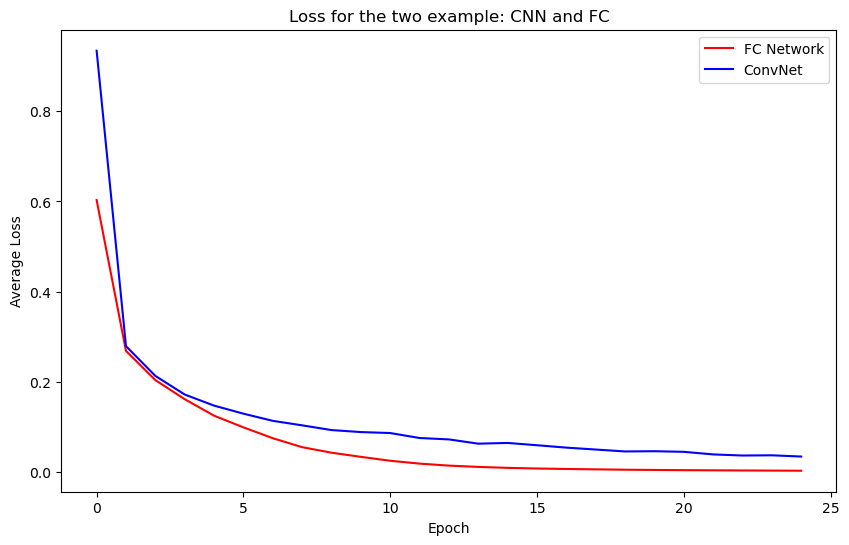

In [50]:
# plot learning curves
plt.figure(figsize=(10, 6))
plt.title("Loss for the two example: CNN and FC")
plt.plot(fc_errors, label="FC Network", color='red')
plt.plot(conv_errors, label="ConvNet", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

###### b) evaluation

> Compare the performance of both models using the MNIST *train* data (60&nbsp;000 images) as test dataset.

In [49]:
# YOUR CODE HERE
# raise NotImplementedError()

train_loader = get_mnist_loader('./data', test=False, batch_size=64, num_workers=4, shuffle=False)

def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs.data, 1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item() 
    accuracy = correct / total
    return torch.tensor(accuracy) 

# Evaluate FC Network
fc_accuracy = evaluate(fc_net, train_loader, calculate_accuracy)

# Evaluate ConvNet
conv_accuracy = evaluate(conv_net, train_loader, calculate_accuracy)

# Calculate average accuracies
fc_avg_accuracy = sum(fc_accuracy) / len(fc_accuracy)
conv_avg_accuracy = sum(conv_accuracy) / len(conv_accuracy)

print(f"FC Network Average Accuracy: {fc_avg_accuracy * 100:.2f}%")
print(f"ConvNet Average Accuracy: {conv_avg_accuracy * 100:.2f}%")


FC Network Average Accuracy: 95.04%
ConvNet Average Accuracy: 95.05%
